In [1]:
import numpy as np
import norfetools as nt
from norfetools import plt
import model.global_Value as G
import model.traffic as gv

import os
import pickle

In [2]:
adjacency_matrix, intersection_dict = gv.InitializeRoadNetwork_ForFigure()

No close intersection found for point (489836.0878875526, 301984.2024015736), closest distance: 540.6062100734734
Failed to find intersections for road between (489836.0878875526, 301984.2024015736) and (490339.8770638752, 302201.24795902625)
No close intersection found for point (489950.15625, 304935.1875), closest distance: 339.0993130275523
Failed to find intersections for road between (490253.3574227325, 305087.0341099371) and (489950.15625, 304935.1875)
No close intersection found for point (489644.23996, 302480.61282), closest distance: 407.2768060832241
Failed to find intersections for road between (489644.23996, 302480.61282) and (490051.51635, 302480.03065)
No close intersection found for point (489950.15625, 304935.1875), closest distance: 339.0993130275523
Failed to find intersections for road between (489950.15625, 304935.1875) and (490253.3574227325, 305087.0341099371)
No close intersection found for point (489644.23996, 302480.61282), closest distance: 407.2768060832241
F

## 工具函数

In [3]:
def binary_array_to_decimal(array):
    # Set values less than 0 to 0 and greater than 0 to 1
    binary_representation = np.where(array > 0, 1, 0)
    
    # Convert the binary array to a string representation
    binary_string = ''.join(str(bit) for bit in binary_representation[::-1])
    
    # Convert the binary string to a decimal number
    decimal_number = int(binary_string, 2)
    
    return decimal_number

def decimal_to_allowed_state(decimal_number):
    # Convert the decimal number to a binary string, removing the '0b' prefix
    binary_str = bin(decimal_number)[2:]
    # Ensure the binary string is 4 digits long by padding with zeros on the left
    binary_str = binary_str.zfill(4)
    # Convert the binary string to a list of -1 and 1, with -1 for '0' and 1 for '1'
    # The conversion should account for the order (0 index is the least significant bit)
    state_list = [1 if digit == '1' else -1 for digit in reversed(binary_str)]
    return state_list

def allowed_state_to_decimal(state_list):
    # Convert the list of -1 and 1 back to a binary string
    # The conversion should account for the order (0 index is the least significant bit)
    binary_str = ''.join(['1' if num == 1 else '0' for num in reversed(state_list)])
    # Convert the binary string to a decimal number
    decimal_number = int(binary_str, 2)
    return decimal_number

def correct_and_count_matrix_states(matrix):
    corrected_matrix = np.empty_like(matrix)
    count_replacements = 0

    # Iterate over the matrix and apply the state transformations
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            state = decimal_to_allowed_state(matrix[i, j])
            mapped_state, changed = G.Map_state(state)
            corrected_matrix[i, j] = allowed_state_to_decimal(mapped_state)
            if changed:
                count_replacements += 1

    return corrected_matrix, count_replacements/(matrix.shape[0]*matrix.shape[1])

In [10]:
def convert_to_decimal(binary_2d_list):
    decimal_list = []

    for binary_list in binary_2d_list:
        # Replace -1 with 1
        converted_list = [0 if num == -1 else num for num in binary_list]
        # Convert the binary list to a string representation
        binary_str = ''.join(str(num) for num in reversed(converted_list))
        # Convert the binary string to a decimal number
        decimal_number = int(binary_str, 2)
        decimal_list.append(decimal_number)

    return decimal_list

allowed_states = convert_to_decimal(G.allowed_states)
# print(allowed_states)

def create_value_to_index_mapping(input_list):
    # Sort the list in descending order while maintaining the original values
    sorted_list = sorted(input_list, reverse=True)[::-1]
    # Create a dictionary mapping each original value to its index in the sorted list
    # Adding 1 to the index to map the range from 1 to len(input_list) instead of 0 to len(input_list)-1
    value_to_index_mapping = {value: index + 1 for index, value in enumerate(sorted_list)}
    return value_to_index_mapping

# Example usage
index_mapping = create_value_to_index_mapping(allowed_states)

In [11]:
def apply_index_mapping_to_matrix(matrix, index_mapping):
    # Apply the index mapping to each element in the matrix
    mapped_matrix = np.vectorize(index_mapping.get)(matrix)
    return mapped_matrix


In [12]:
# 结果映射
def correct_and_count_matrix_states(matrix):
    corrected_matrix = np.empty_like(matrix)
    count_replacements = 0

    # Iterate over the matrix and apply the state transformations
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            state = decimal_to_allowed_state(matrix[i, j])
            mapped_state, changed = G.Map_state(state)
            corrected_matrix[i, j] = allowed_state_to_decimal(mapped_state)
            if changed:
                count_replacements += 1

    return corrected_matrix, count_replacements/(matrix.shape[0]*matrix.shape[1])


In [5]:
def load_state_data(directory, file_pattern, num_steps):
    # Initialize an empty list to hold data for all steps
    all_steps_data = []
    
    # Loop over the number of time steps
    for step in range(num_steps):
        file_path = os.path.join(directory, file_pattern.format(step))
        with open(file_path, 'rb') as file:
            # Load the state data from the current file
            state_data = pickle.load(file)
            
            # Assume state_data is a dictionary with keys as nodes and values as states
            step_states = [state_data[node] for node in sorted(state_data.keys())]
            all_steps_data.append(step_states[:])
    
    # Convert the list of steps data to a numpy array, where each row is a time step
    all_data_array = np.array(all_steps_data)  # Transpose to make rows as nodes and columns as time steps
    
    return all_data_array.T

def load_state_data_forSB(directory, file_pattern, num_steps):
    # Initialize an empty list to hold data for all steps
    all_steps_data = []
    
    # Loop over the number of time steps
    for step in range(num_steps):
        file_path = os.path.join(directory, file_pattern.format(step))
        with open(file_path, 'rb') as file:
            # Load the state data from the current file
            state_data = pickle.load(file)
            
            # Convert the state data from +-1 to binary string, then to decimal, and finally to hex
            step_states_hex = [binary_array_to_decimal(state_data[:,i]) for i in range(state_data.shape[1])]
            all_steps_data.append(step_states_hex[:])
    
    # Convert the list of steps data to a numpy array, where each row is a node and each column a time step
    all_data_array = np.array(all_steps_data)

    return all_data_array.T

In [14]:
# Usage
directory = "Y:/2023-Traffic/Result/TimeList/SA_eta1.0_Hwa-2.0"
file_pattern = "time_step_{}.pkl"
num_steps = 3  # Assuming there are 100 time steps from 0 to 99

# Load the data
all_data_SA = load_state_data(directory, file_pattern, num_steps)


# UsageResult/TimeList/SA_eta1.0_Hwa-2.0
directory = "Y:/2023-Traffic/Result/TimeList/SB_eta1.0_Hwa-2.0"
file_pattern = "time_step_{}.pkl"
num_steps = 3  # Assuming there are 100 time steps from 0 to 99

# Load the data
all_data_SB = load_state_data_forSB(directory, file_pattern, num_steps)

print(all_data_SA.shape, all_data_SB.shape)

corrected_matrix, num_replacements = correct_and_count_matrix_states(all_data_SA)
corrected_matrix_SB, num_replacements_SB = correct_and_count_matrix_states(all_data_SB)

print(corrected_matrix, num_replacements, corrected_matrix_SB, num_replacements_SB)

mapped_matrix = apply_index_mapping_to_matrix(corrected_matrix, index_mapping)
mapped_matrix_SB = apply_index_mapping_to_matrix(corrected_matrix_SB, index_mapping)

print(mapped_matrix, mapped_matrix_SB)

(379, 3) (378, 3)
[[13 13 13]
 [ 7  5  5]
 [13  5  5]
 ...
 [ 2  5  5]
 [ 7  5  5]
 [10  8  8]] 0.357080035180299 [[ 2  0  2]
 [ 2  5  5]
 [ 0  0 10]
 ...
 [ 0  0  0]
 [ 0  0  0]
 [ 0  0  0]] 0.48324514991181655
[[7 7 7]
 [4 3 3]
 [7 3 3]
 ...
 [2 3 3]
 [4 3 3]
 [6 5 5]] [[2 1 2]
 [2 3 3]
 [1 1 6]
 ...
 [1 1 1]
 [1 1 1]
 [1 1 1]]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_heatmap_with_custom_labels(matrix, index_mapping):
    # Create a list of colors from the Accent colormap for the first 8 colors
    colors = plt.cm.Accent.colors[:8]

    # Create a custom colormap
    custom_cmap = mcolors.ListedColormap(colors)

    # Normalize the color map to integers 1 through 8
    norm = mcolors.BoundaryNorm(range(1, 10), custom_cmap.N)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(5, 3))
    cax = ax.imshow(matrix, cmap=custom_cmap, norm=norm, aspect="auto")

    # Create a reversed mapping from index to original value
    reversed_mapping = {v: k for k, v in index_mapping.items()}

    # Create colorbar with custom labels positioned at the center of each color
    # Map 1-8 to the original values in the index mapping, then convert to binary string
    cbar_labels = [format(reversed_mapping[i], '04b') for i in range(1, 9)]
    cbar = plt.colorbar(cax, ticks=np.arange(1.5, 9.5, 1))  # Set ticks at the center of each color
    cbar.ax.set_yticklabels(cbar_labels)

    # Label the axes
    ax.set_xlabel('Time')
    ax.set_ylabel('Row Index')
    # ax.set_title('Heatmap with Custom Binary Labels (Centered Ticks)')

    # plt.show()

plot_heatmap_with_custom_labels(mapped_matrix, index_mapping)
# Dplt.SaveFig(1,"SA-heatmap.png","Figure/Timelist/")
# plt.close()

plot_heatmap_with_custom_labels(mapped_matrix_SB, index_mapping)
# Dplt.SaveFig(1,"SB-heatmap.png","Figure/Timelist/")
# plt.close()

# 汇总表显示

ValueError: x and y must have same first dimension, but have shapes (4,) and (20,)

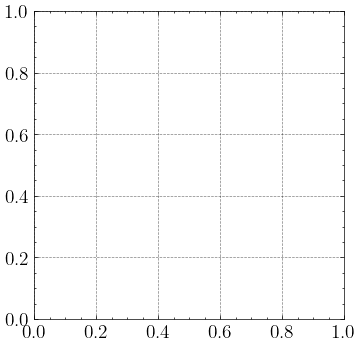

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dual_axis(durations_array, intervals_array, colors):
    # 横轴为四个状态
    states = np.array([1, 2, 3, 4])

    # 为前三个Hwa值定义不同的线型
    line_styles = ['-', '--', '-.']

    # 确保提供了两种颜色
    if len(colors) != 2:
        raise ValueError("Please provide exactly two colors.")

    fig, ax1 = plt.subplots(figsize=(4,4))

    # 绘制durations_array的前三个Hwa值
    for i in range(3):
        ax1.plot(states, durations_array[:, :, i].mean(axis=0), line_styles[i], label=f'$\zeta=10^{{{i-6}}}$', color=colors[0])
    ax1.set_ylim(-10,400)
    ax1.set_xlabel('$\eta$')
    ax1.set_ylabel(r'$t_{\text{Dur}}$', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.set_xticks(states)
    ax1.set_xticklabels([f'$10^{{1}}$', f'$10^{{2}}$', f'$10^{{3}}$', f'$10^{{4}}$'])

    # 创建第二个纵轴
    ax2 = ax1.twinx()
    # 绘制intervals_array的前三个Hwa值
    for i in range(3):
        ax2.plot(states, intervals_array[:, :, i].mean(axis=0), line_styles[i], label=f'$\zeta=10^{{{i-6}}}$', color=colors[1])
    ax2.set_ylim(-10,400)
    ax2.set_ylabel(r'$t_{\text{Int}}$', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])

    # 图例
    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax2.transAxes, ncol=2, fontsize = 9)
    
    # plt.title('Durations and Intervals')


durations_array, intervals_array = nt.Load_data("Result/timelist_array.pkl")
# 绘制图表
plot_dual_axis(durations_array, intervals_array, colors=['#1e3666', '#fbab4d'])
nt.SaveFig(1, "timelist_array.png")

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dual_axis_SASB(durations_array, intervals_array, colors):
    # 横轴为四个状态
    # states = np.array([1, 2, 3, 4])
    states = np.arange(1, 2.95, 0.1)

    # 为前三个Hwa值定义不同的线型
    line_styles = ['-', '--', '-.']

    # 确保提供了两种颜色
    if len(colors) != 2:
        raise ValueError("Please provide exactly two colors.")

    fig, ax1 = plt.subplots(figsize=(4,4))

    # 绘制durations_array的前三个Hwa值
    # for i in range(3):
    i = 0

    ax1.plot(states, durations_array[0, :, i], line_styles[1], label=f'SA:$\zeta=10^{{{i-6}}}$', color=colors[0])
    ax1.plot(states, durations_array[1, :, i], line_styles[0], label=f'SB:$\zeta=10^{{{i-6}}}$', color=colors[0])
    ax1.set_ylim(-10,400)
    ax1.set_xlabel('$\eta$')
    ax1.set_ylabel(r'$t_{\text{Dur}}$', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    # ax1.set_xticks(states)
    # ax1.set_xticklabels([f'$10^{{1}}$', f'$10^{{2}}$', f'$10^{{3}}$', f'$10^{{4}}$'])

    # 创建第二个纵轴
    ax2 = ax1.twinx()
    # 绘制intervals_array的前三个Hwa值
    # for i in range(3):
    ax2.plot(states, intervals_array[0, :, i], line_styles[1], label=f'SA:$\zeta=10^{{{i-6}}}$', color=colors[1])
    ax2.plot(states, intervals_array[1, :, i], line_styles[0], label=f'SB:$\zeta=10^{{{i-6}}}$', color=colors[1])
    ax2.set_ylim(-10,400)
    ax2.set_ylabel(r'$t_{\text{Int}}$', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])

    # 图例
    fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax2.transAxes, ncol=2, fontsize = 9)
    
    # plt.title('Durations and Intervals')


durations_array, intervals_array = nt.Load_data("Result/timelist_array.pkl")
# 绘制图表
plot_dual_axis_SASB(durations_array, intervals_array, colors=['#1e3666', '#fbab4d'])
nt.SaveFig(1, "timelist_array_SASB.png")

In [78]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev

def plot_single_axis_SASB(durations_array, intervals_array, colors):
    # 横轴为四个状态
    states = np.arange(1, 2.05, 0.1)
    durations_array = durations_array[:, :-9, :]
    intervals_array = intervals_array[:, :-9, :]

    # 为前三个Hwa值定义不同的线型
    line_styles = ['-', '--', '-.']

    # 确保提供了两种颜色
    if len(colors) != 2:
        raise ValueError("Please provide exactly two colors.")

    fig, ax = plt.subplots(figsize=(4,7))

    # 绘制durations_array的前三个Hwa值
    ax.scatter(states, durations_array[0, :, 0], marker='^', label=r'$t_{\text{Dur}}$(SA)', color=colors[0], zorder=5, s=3)
    ax.scatter(states, durations_array[1, :, 0], marker='^', label=r'$t_{\text{Dur}}$(SB)', color=colors[1], zorder=5, s=3)

    # 样条拟合并绘制平滑曲线
    tck_SA = splrep(states, durations_array[0, :, 0], s=50)
    tck_SB = splrep(states, durations_array[1, :, 0], s=50)

    # 使用样条拟合生成平滑曲线
    smooth_SA = splev(states, tck_SA)
    smooth_SB = splev(states, tck_SB)

    # 绘制平滑曲线
    ax.plot(states, smooth_SA, line_styles[0], color=colors[0])
    ax.plot(states, smooth_SB, line_styles[0], color=colors[1])

    ax.plot(states, smooth_SA*7, line_styles[1], label=r'$t_{\text{Int-Theory}}$(SA)', color=colors[0], alpha = 0.5)
    ax.plot(states, smooth_SB*7, line_styles[1], label=r'$t_{\text{Int-Theory}}$(SB)', color=colors[1], alpha = 0.5)

    # 绘制intervals_array的前三个Hwa值
    ax.scatter(states, intervals_array[0, :, 0], marker='v', label=r'$t_{\text{Int}}$(SA)', color=colors[0], s=5)
    ax.scatter(states, intervals_array[1, :, 0], marker='v', label=r'$t_{\text{Int}}$(SB)', color=colors[1], s=5)

    # 设置Y轴标签并调整其范围
    ax.set_ylim(-10, 200)
    ax.set_xlabel('$\eta$')
    ax.set_ylabel(r'$t_{\text{Dur}}$ or $t_{\text{Int}}$', color='black')

    ax.set_xticks([1,2])
    ax.set_xticklabels([f'$10^{{1}}$', f'$10^{{2}}$'])

    # 使用不同的颜色标识两个数据集
    ax.tick_params(axis='y', labelcolor='black')

    # 图例
    fig.legend(loc="upper left", bbox_to_anchor=(0, 1), bbox_transform=ax.transAxes, ncol=1, fontsize=10, frameon=False)

    # plt.title('Durations and Intervals')
    plt.tight_layout()

# 示例数据加载
durations_array, intervals_array = nt.Load_data("Result/timelist_array.pkl")

# 绘制图表
# plot_single_axis_SASB(durations_array, intervals_array, colors=['#1e3666', '#fbab4d'])
plot_single_axis_SASB(durations_array, intervals_array, colors=['#1c499e', '#e7141a'])

# 保存图像
nt.SaveFig(1, "timelist_array_SASB.png")

In [3]:

def plot_replacements(replacements, colors):
    if replacements.shape != (2, 4, 5):
        raise ValueError("The shape of the replacements array should be (2, 2, 5).")

    # 确保提供了两种颜色
    if len(colors) != 2:
        raise ValueError("Please provide exactly two colors.")

    # 定义i和j的值
    i_values = np.array([1, 2, 3, 4])
    j_values = np.array([-6, -5, -4, -3, -2])

    # 为不同的j值定义线型
    line_styles = ['-', '--', '-.', ':']

    fig, ax1 = plt.subplots(figsize=(4, 4))

    # 绘制SA的数据
    for i_idx, i in enumerate(i_values):
        ax1.plot(j_values, replacements[0, i_idx, :], line_styles[i_idx], label=f'$\eta = 10^{i}$', color=colors[0])
    ax1.set_xlabel('$H_{wa}$')
    ax1.set_ylabel('SA Replacements', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax1.set_xticks(j_values)
    ax1.set_xticklabels([f"$10^{{{j}}}$" for j in j_values])
    ax1.set_ylim(0.1,0.7)

    # 创建第二个纵轴用于SB的数据
    ax2 = ax1.twinx()
    for i_idx, i in enumerate(i_values):
        ax2.plot(j_values, replacements[1, i_idx, :], line_styles[i_idx], label=f'$\eta = 10^{i}$', color=colors[1])
    ax2.set_ylabel('SB Replacements', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
    ax2.set_ylim(0.1,0.7)

    # 图例
    fig.legend(loc="lower left", bbox_to_anchor=(0,1.08), bbox_transform=ax2.transAxes, ncol=2)

    plt.title('Replacements for SA and SB')

# 使用示例
# 假设replacements是一个(2, 2, 5)形状的数组
# replacements = np.random.rand(2, 2, 5)  # 随机数据，仅用于示例

replacements = nt.Load_data("Result/replacements_array.pkl")
plot_replacements(replacements[:,:,::-1], colors=['#1e3666', '#fbab4d'])

nt.SaveFig(1, "replacements-array.png")

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin(matrix, palette="Set2"):
    """
    绘制小提琴图，横轴为np.arange(1, 2.85, 0.1)，纵轴为矩阵的值（百分比显示），第二维度为SA和SB类别。

    参数:
    matrix: 形状为(19, 2, 360)的numpy数组。
    palette: 自定义的小提琴图颜色调色板（默认使用 "Set2"）。
    """
    # 确保矩阵形状为 (19, 2, 360)
    # if matrix.shape != (19, 2, 360):
    #     raise ValueError("输入矩阵的形状必须为(19, 2, 360)")

    # 创建np.arange作为横轴
    x_values = np.arange(1, 2.05, 0.1)

    # 准备一个空的列表来存储数据
    plot_data = []

    # 填充数据
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            category = 'SA' if j == 0 else 'SB'  # 根据第二维来区分SA和SB
            for value in matrix[i, j]:
                plot_data.append([x_values[i], category, value * 100])  # 转换为百分比

    # 将数据转换为DataFrame
    df = pd.DataFrame(plot_data, columns=['X', 'Category', 'Value'])

    # 绘制小提琴图
    plt.figure(figsize=(7, 4))
    ax = sns.violinplot(x='X', y='Value', hue='Category', data=df, split=True, inner="quart", palette=palette)

    # 设置x轴的刻度
    ax.set_xticks([0, 10])  # 只显示1, 2, 3对应的刻度
    ax.set_xticklabels([r'$10^{1}$', r'$10^{2}$'])  # 设置这些刻度的标签为10的幂
    
    # 调整分位线的颜色为白色，并改为实线
    # 专门处理小提琴图的分位线
    quartile_lines = []  # 用于存储分位线的对象
    for line in ax.findobj(match=plt.Line2D):  # 查找所有线条对象
        if line.get_data()[0] is not None:  # 检查线条是否有数据
            quartile_lines.append(line)

    # 修改分位线的样式
    for line in quartile_lines:
        line.set_color('white')  # 设置分位线颜色为白色
        line.set_linestyle('-')  # 设置分位线样式为实线
        line.set_linewidth(1)  # 设置线宽

    # 添加图例标题（单位为百分比）
    legend = ax.legend(title='', loc='upper left', ncol=2)

    # 设置图表标题和标签
    plt.xlabel(r'$\eta$')
    plt.ylabel(r'$H_{\text{d}} / H$ (\%)')  # 纵轴显示为百分比

    plt.ylim(-5, 120)

    ax.grid(":", alpha=0.2)

# 示例使用
Hq_rate_array = nt.Load_data("Result\Hq_rate_array.pkl")
plot_violin(Hq_rate_array[:11,:,:], palette=['#1c499e', '#e7141a'])
nt.SaveFig(1, "Hq_rate_array.png")